# CHECKPOINT 1

# Loading file

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import json
import seaborn as sns

from skimage import img_as_float, util
from skimage import color
from skimage.color import rgb2gray, rgb2hsv
from skimage.transform import rescale, downscale_local_mean
from skimage.feature import local_binary_pattern
from sklearn.utils import resample

from sklearn.model_selection import train_test_split, cross_val_score, KFold
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, f1_score
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.pipeline import make_pipeline

In [2]:
# Reading from HDF5
df = pd.read_hdf('../../data/Regression/all_training.h5', 'train_df')
train_df = df
train_df

,disaster,image,label,height,width,size
0,hurricane-matthew,"[[[58, 94, 83], [60, 97, 86], [61, 98, 86], [6...",3,65,54,10530
1,hurricane-matthew,"[[[150, 177, 183], [147, 174, 182], [153, 180,...",0,67,105,21105
2,hurricane-matthew,"[[[59, 81, 75], [53, 75, 69], [47, 68, 62], [5...",1,54,56,9072
3,hurricane-matthew,"[[[194, 209, 205], [137, 161, 157], [99, 127, ...",0,114,124,42408
4,hurricane-matthew,"[[[127, 156, 147], [134, 165, 159], [129, 162,...",2,58,51,8874
...,...,...,...,...,...,...
26530,midwest-flooding,"[[[60, 94, 76], [65, 99, 82], [66, 102, 84], [...",0,29,29,2523
26531,midwest-flooding,"[[[84, 122, 114], [87, 120, 116], [87, 117, 11...",0,144,39,16848
26532,midwest-flooding,"[[[53, 80, 57], [55, 81, 60], [60, 86, 66], [6...",0,86,64,16512
26533,midwest-flooding,"[[[39, 69, 43], [39, 69, 44], [39, 69, 44], [3...",0,116,140,48720


,count
disaster,
hurricane-matthew,11151
midwest-flooding,7004
socal-fire,8380


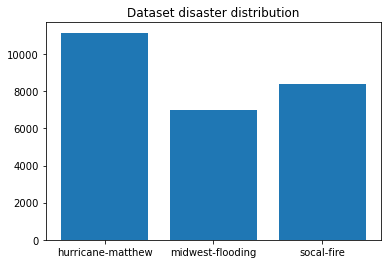

In [3]:
distribution = train_df[["disaster", "size"]].groupby("disaster").count().rename(columns={"size": "count"})
plt.title("Dataset disaster distribution")
plt.bar(x=distribution.index, height=distribution["count"])
distribution

# Image sizes across disasters

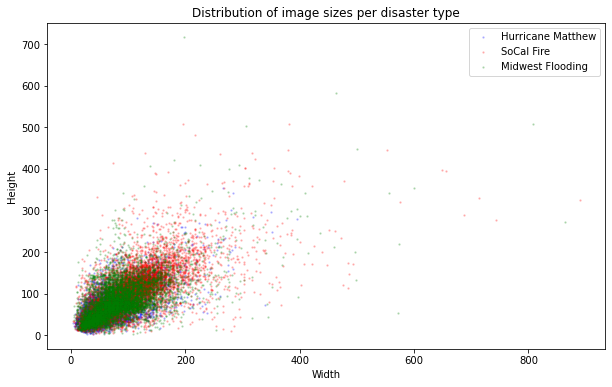

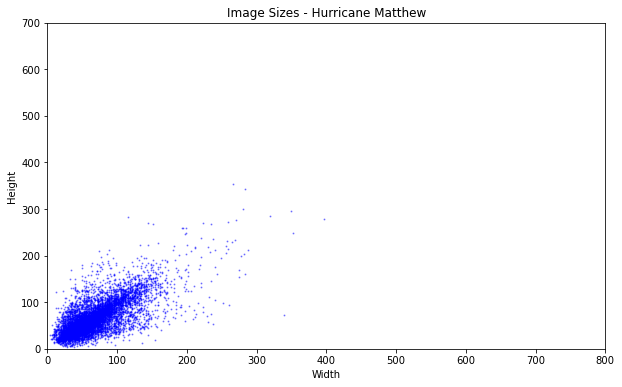

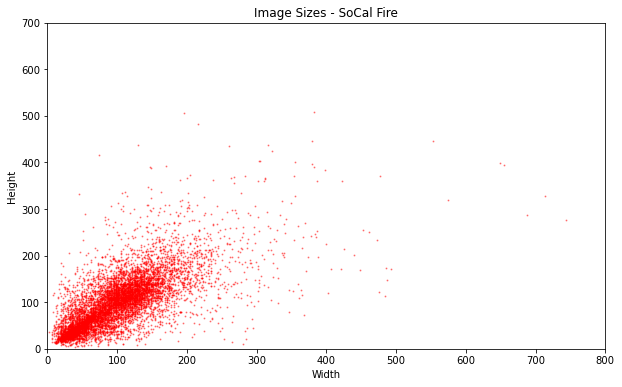

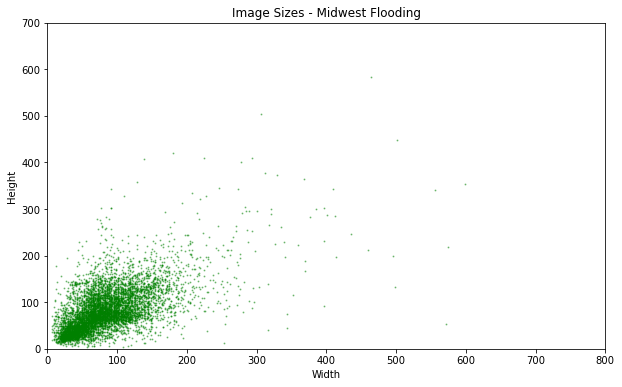

In [4]:
hurricane_matthew = train_df[train_df['disaster'] == 'hurricane-matthew']['image']
socal_fire = train_df[train_df['disaster'] == 'socal-fire']['image']
midwest_flooding = train_df[train_df['disaster'] == 'midwest-flooding']['image']

sizes_hurricane_matthew = np.array([img.shape for img in hurricane_matthew])
sizes_socal_fire = np.array([img.shape for img in socal_fire])
sizes_midwest_flooding = np.array([img.shape for img in midwest_flooding])

plt.figure(figsize=(10, 6))
plt.scatter(sizes_hurricane_matthew[:, 1], sizes_hurricane_matthew[:, 0], alpha=0.2, label="Hurricane Matthew", color="blue", s=2)
plt.scatter(sizes_socal_fire[:, 1], sizes_socal_fire[:, 0], alpha=0.2, label="SoCal Fire", color="red", s=2)
plt.scatter(sizes_midwest_flooding[:, 1], sizes_midwest_flooding[:, 0], alpha=0.2, label="Midwest Flooding", color="green", s=2)

plt.title("Distribution of image sizes per disaster type")
plt.xlabel("Width")
plt.ylabel("Height")
plt.legend()
plt.show()


def plot_image_sizes(sizes, title, color):
    plt.figure(figsize=(10, 6))
    plt.scatter(sizes[:, 1], sizes[:, 0], alpha=0.4, color=color, s=1)
    plt.title("Image Sizes - " + title)
    plt.ylim(0, 700)
    plt.xlim(0, 800)
    plt.xlabel("Width")
    plt.ylabel("Height")
    plt.show()

plot_image_sizes(sizes_hurricane_matthew, "Hurricane Matthew", "blue")
plot_image_sizes(sizes_socal_fire, "SoCal Fire", "red")
plot_image_sizes(sizes_midwest_flooding, "Midwest Flooding", "green")


# Distribution of labels

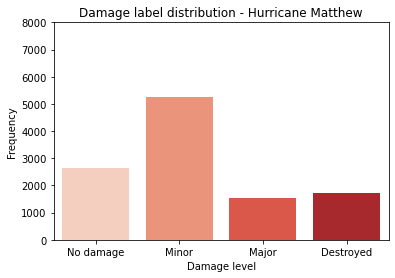

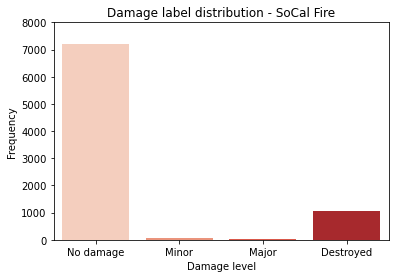

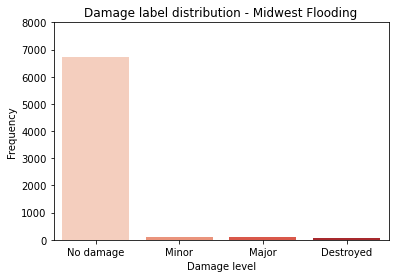

In [5]:
damage_labels_hurricane_matthew = np.array(train_df[train_df['disaster'] == 'hurricane-matthew']["label"])
damage_labels_socal_fire = np.array(train_df[train_df['disaster'] == 'socal-fire']["label"])
damage_labels_midwest_flooding = np.array(train_df[train_df['disaster'] == 'midwest-flooding']["label"])

def plot_label_distribution_each_disaster(labels, title):
    plt.figure(figsize=(6, 4))
    sns.countplot(x=labels, palette="Reds")
    plt.title("Damage label distribution - " + title)
    plt.ylim(0, 8000)
    plt.xlabel('Damage level')
    plt.ylabel('Frequency')
    plt.xticks(range(4), ['No damage', 'Minor', 'Major', 'Destroyed'])
    plt.show()

plot_label_distribution_each_disaster(damage_labels_hurricane_matthew, 'Hurricane Matthew')
plot_label_distribution_each_disaster(damage_labels_socal_fire, 'SoCal Fire')
plot_label_distribution_each_disaster(damage_labels_midwest_flooding, 'Midwest Flooding')

# Task A - EDA and final features

**RGB and HSV channels**

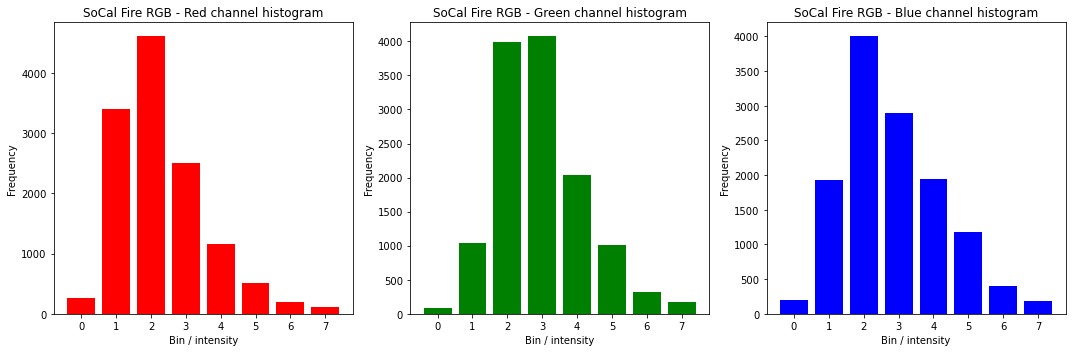

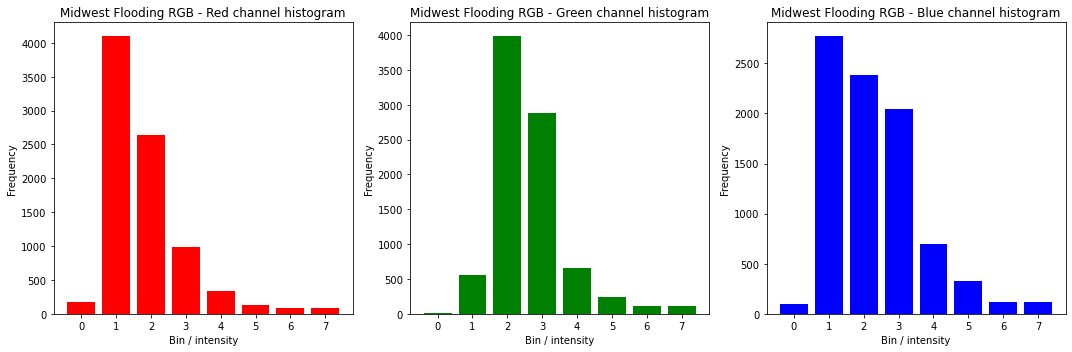

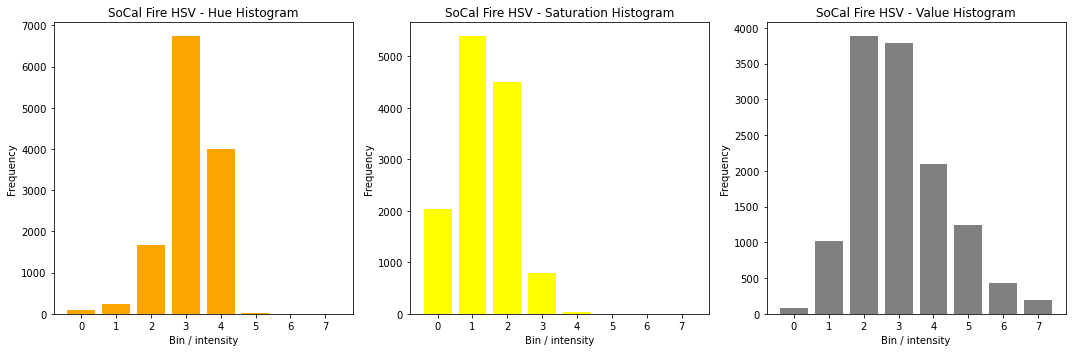

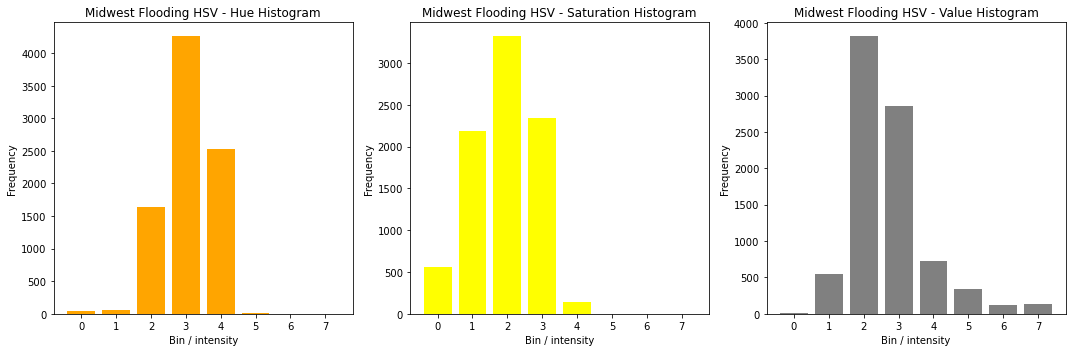

In [6]:
from skimage.color import rgb2hsv


# For this task we looked at the difference in color for SoCal Fire and Midwest Flooding

# First we defined our dataframe with only SoCal and Midwest

socal_fire_df = train_df[train_df['disaster'] == 'socal-fire']
midwest_flood_df = train_df[train_df['disaster'] == 'midwest-flooding']


# Then we plotted a histogram for every RGB channel per disaster, where each histogram has a total of 8 bins
# Shows the average of all images for each channel

# Calculate histograms for RGB channels
def calculate_rgb_histograms(image_data, bins=8):
    histograms = {'red': [], 'green': [], 'blue': []}
    for image in image_data:
        histograms['red'].append(np.histogram(image[:, :, 0], bins=bins, range=(0, 255))[0])
        histograms['green'].append(np.histogram(image[:, :, 1], bins=bins, range=(0, 255))[0])
        histograms['blue'].append(np.histogram(image[:, :, 2], bins=bins, range=(0, 255))[0])
    for key in histograms:
        histograms[key] = np.mean(histograms[key], axis=0)
    return histograms

# Plot the histograms
def plot_rgb_histograms(histograms, title):
    fig, axes = plt.subplots(1, 3, figsize=(15, 5))  # Adjust the figsize if necessary
    color_labels = ['Red', 'Green', 'Blue']
    colors = ['red', 'green', 'blue']
    
    for i, ax in enumerate(axes):
        ax.bar(range(len(histograms[color_labels[i].lower()])), histograms[color_labels[i].lower()], color=colors[i])
        ax.set_title(f'{title} - {color_labels[i]} channel histogram')
        ax.set_xlabel('Bin / intensity')
        ax.set_ylabel('Frequency')
    
    plt.tight_layout() 
    plt.show()



# Then we did the same for each channel in HSV


# Calculate histograms for HSV channels
def calculate_hsv_histograms(image_data, bins=8):
    histograms = {'hue': [], 'saturation': [], 'value': []}
    for image in image_data:
        hsv_image = rgb2hsv(image)
        histograms['hue'].append(np.histogram(hsv_image[:, :, 0], bins=bins, range=(0, 1))[0])
        histograms['saturation'].append(np.histogram(hsv_image[:, :, 1], bins=bins, range=(0, 1))[0])
        histograms['value'].append(np.histogram(hsv_image[:, :, 2], bins=bins, range=(0, 1))[0])
    for key in histograms:
        histograms[key] = np.mean(histograms[key], axis=0)
    return histograms

# Plot the histograms
def plot_hsv_histograms(histograms, title):
    fig, axes = plt.subplots(1, 3, figsize=(15, 5))
    color_labels = ['Hue', 'Saturation', 'Value']
    colors = ['orange', 'yellow', 'grey']
    for i, ax in enumerate(axes):
        ax.bar(range(len(histograms[color_labels[i].lower()])), histograms[color_labels[i].lower()], color=colors[i])
        ax.set_title(f'{title} - {color_labels[i]} Histogram')
        ax.set_xlabel('Bin / intensity')
        ax.set_ylabel('Frequency')
    
    plt.tight_layout()
    plt.show()



# Calculate and plot histograms

# RGB
socal_fire_histograms = calculate_rgb_histograms(socal_fire_df['image'].values)
midwest_flood_histograms = calculate_rgb_histograms(midwest_flood_df['image'].values)

plot_rgb_histograms(socal_fire_histograms, 'SoCal Fire RGB')
plot_rgb_histograms(midwest_flood_histograms, 'Midwest Flooding RGB')

# HSV

socal_fire_hsv_histograms = calculate_hsv_histograms(socal_fire_df['image'].values)
midwest_flood_hsv_histograms = calculate_hsv_histograms(midwest_flood_df['image'].values)

plot_hsv_histograms(socal_fire_hsv_histograms, 'SoCal Fire HSV')
plot_hsv_histograms(midwest_flood_hsv_histograms, 'Midwest Flooding HSV')

# Task B - EDA and final features

**RGB and HSV channels**

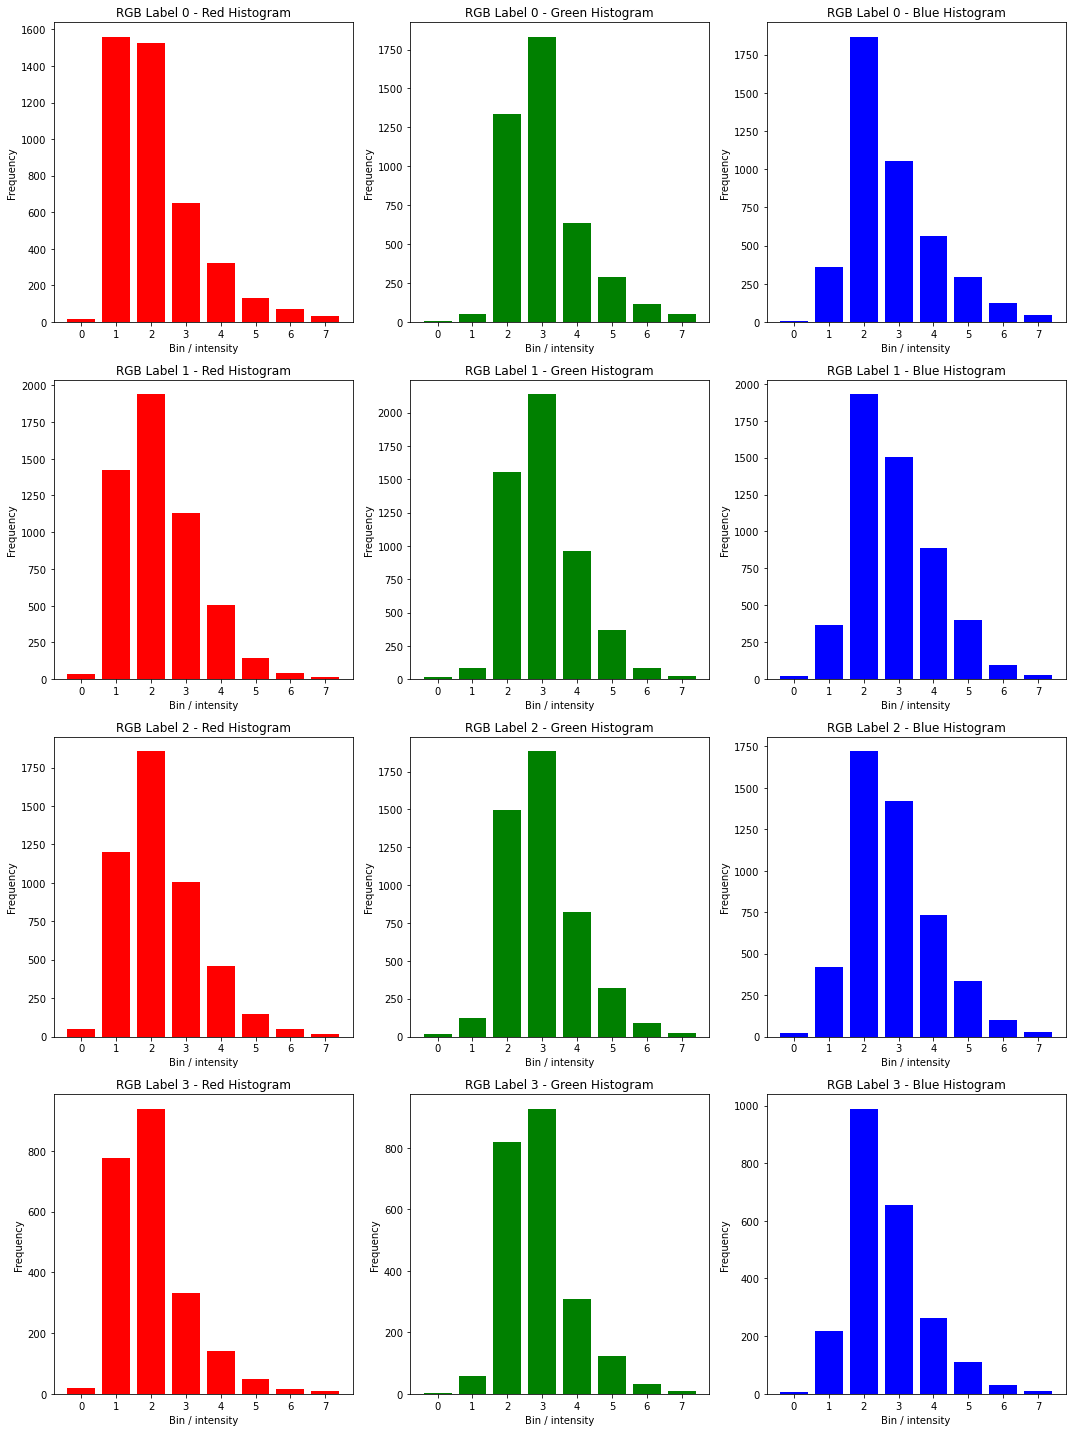

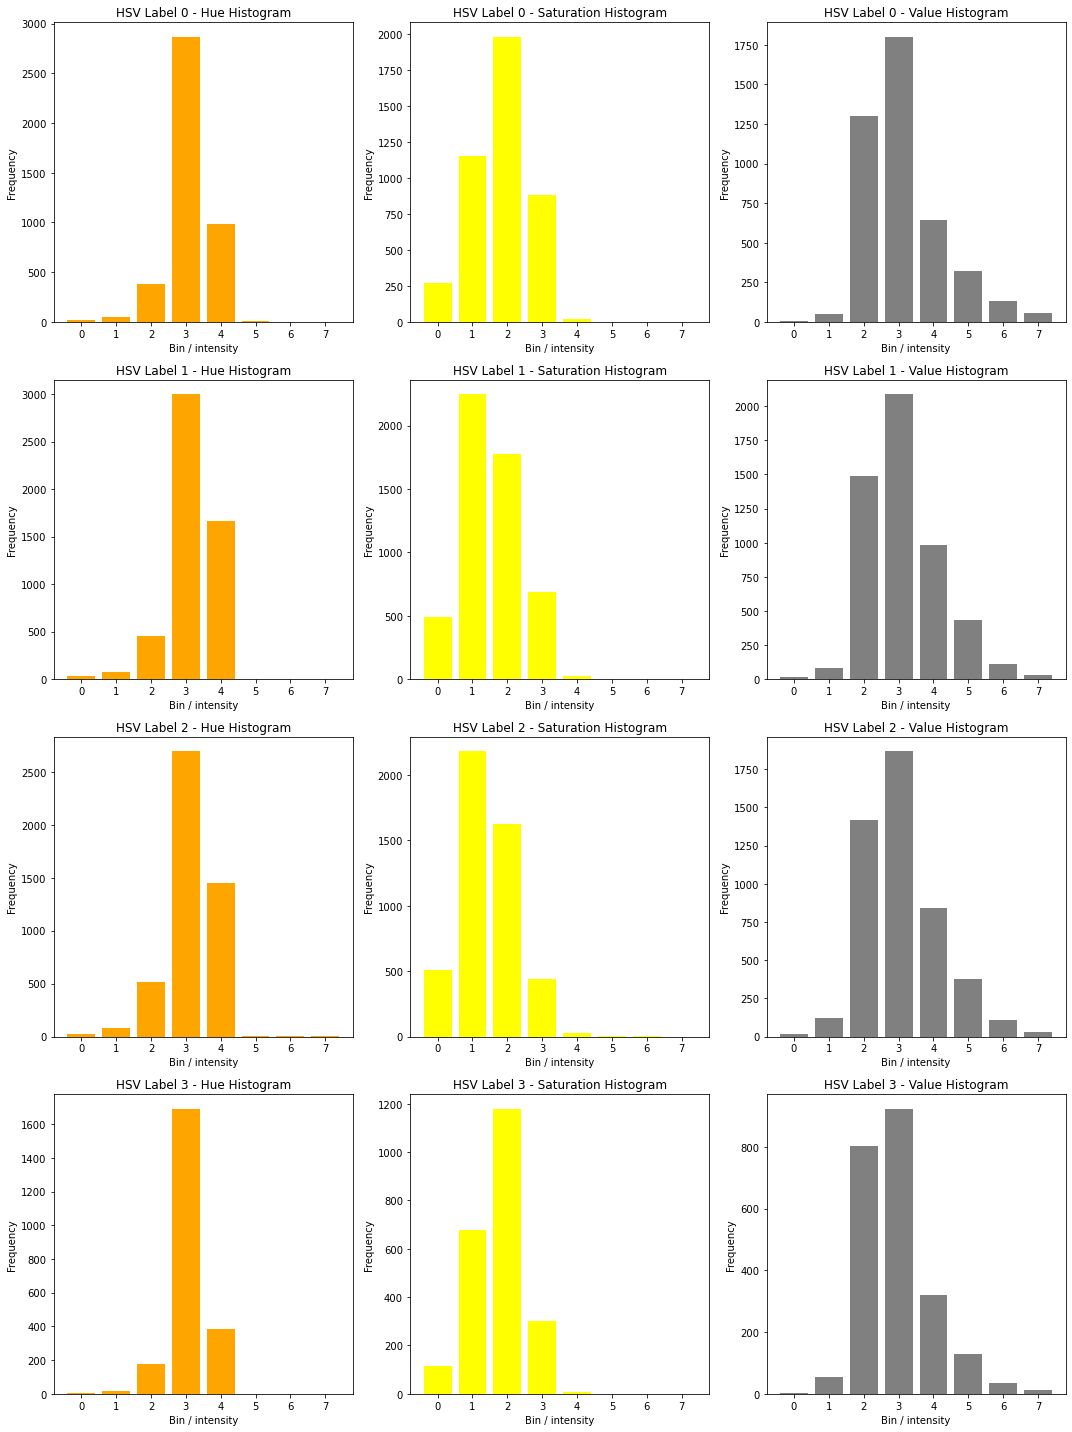

In [7]:
# The first features we looked at where RGB and HSV for each label


def plot_all_labels_histograms(histograms, title_prefix):
    fig, axes = plt.subplots(nrows=4, ncols=3, figsize=(15, 20))
    if 'red' in histograms[0]:
        color_labels = ['Red', 'Green', 'Blue']
    else:
        color_labels = ['Hue', 'Saturation', 'Value']
    if 'red' in histograms[0]:
        colors = ['red', 'green', 'blue'] 
    else:
        colors = ['orange', 'yellow', 'grey']
    
    for i, label in enumerate(labels):
        for j, (key, color) in enumerate(zip(color_labels, colors)):
            axes[i, j].bar(range(len(histograms[label][key.lower()])), histograms[label][key.lower()], color=color)
            axes[i, j].set_title(f'{title_prefix} {label} - {key} Histogram')
            axes[i, j].set_xlabel('Bin / intensity')
            axes[i, j].set_ylabel('Frequency')

    plt.tight_layout()
    plt.show()

# filter out labels
labels = [0, 1, 2, 3]
hurricane_data = {
    label: train_df[(train_df['disaster'] == 'hurricane-matthew') & (train_df['label'] == label)]['image'].values
    for label in labels
}

# Calculate, store and plot histograms for each label
rgb_histograms = {label: calculate_rgb_histograms(hurricane_data[label]) for label in labels}
hsv_histograms = {label: calculate_hsv_histograms(hurricane_data[label]) for label in labels}

plot_all_labels_histograms(rgb_histograms, 'RGB Label')
plot_all_labels_histograms(hsv_histograms, 'HSV Label')

**Contrast**

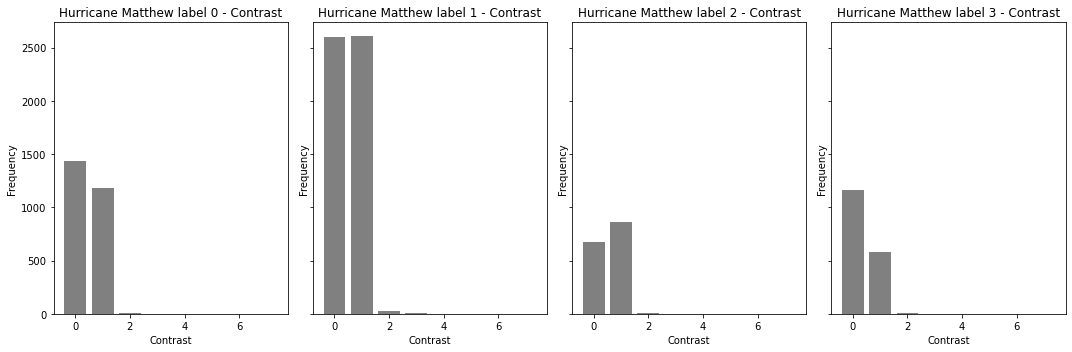

In [8]:
# Then we looked at contrast to see if there were any correlation between labels and variating intensity in the images

def compute_contrast_and_bin(image, bins=5):
    image_gray = rgb2gray(img_as_float(image))
    contrast = np.std(image_gray.flatten())
    bins_edges = np.linspace(0, np.max([image_gray.max(), 0.5]), bins+1)
    bin_index = np.digitize(contrast, bins_edges) - 1
    return bin_index

def calculate_contrast_histograms(data, bins=8):
    contrast_histograms = {label: np.zeros(bins) for label in labels}
    for label in labels:
        for image in data[label]:
            bin_index = compute_contrast_and_bin(image, bins)
            contrast_histograms[label][bin_index] += 1
    return contrast_histograms

def plot_contrast_histograms(histograms, title_prefix):
    fig, axes = plt.subplots(1, len(histograms), figsize=(15, 5), sharey=True)
    for i, (label, histogram) in enumerate(histograms.items()):
        axes[i].bar(range(len(histogram)), histogram, color='gray')
        axes[i].set_title(f'{title_prefix} {label} - Contrast')
        axes[i].set_xlabel('Contrast')
        axes[i].set_ylabel('Frequency')
    plt.tight_layout()
    plt.show()

contrast_histograms = calculate_contrast_histograms(hurricane_data)
plot_contrast_histograms(contrast_histograms, 'Hurricane Matthew label')

From the results of the plot, we can see that labels 2 and 3 have significant lower contrast. Label 0 is in the middle range, while label 1 is clearly higher than the other labels. The reason for this huge difference for label 1 may be caused by a larger amount of debris around the building. A large amount of debris may cause a high variation in intensity in the image (therefore higher contrast).

**Local Binary Pattern**

/home/ubuntu/.local/lib/python3.10/site-packages/skimage/feature/texture.py:360: UserWarning: Applying `local_binary_pattern` to floating-point images may give unexpected results when small numerical differences between adjacent pixels are present. It is recommended to use this function with images of integer dtype.
  warnings.warn(


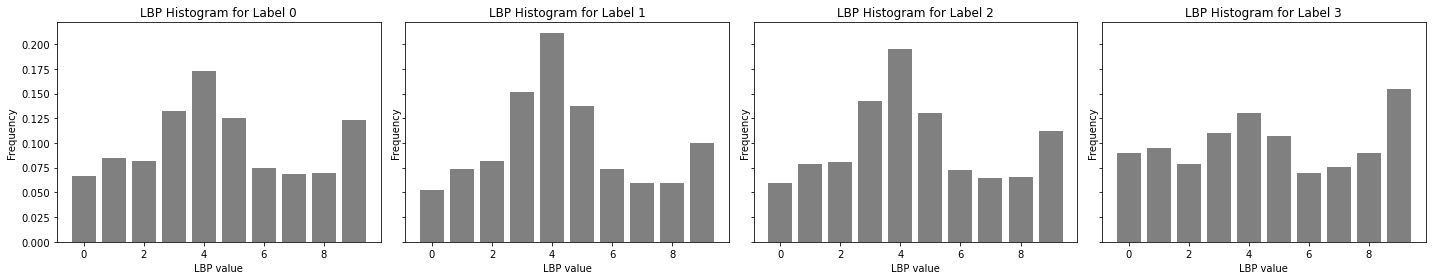

In [9]:
# Then we looked at LBP since this methode is good for see patterns of edges which is relevant after a hurricane might have destroyed a building

# LBP features
# Have to convert to grayscale since LBP only uses intensity and not color (P and R is neighbors and radius)
# Using uniform patterns to reduce complexity
def extract_lbp_features(img, P=8, R=1, method='uniform'):
    img_grayscaled = rgb2gray(img)
    lbp = local_binary_pattern(img_grayscaled, P, R, method)
    n_bins = int(lbp.max() + 1)
    hist, _ = np.histogram(lbp, density=True, bins=n_bins, range=(0, n_bins))
    return hist

# Dividing labels and store lbp info for each label
labels = [0, 1, 2, 3]
lbp_features_by_label = {}

for label in labels:
    images = train_df[(train_df['disaster'] == 'hurricane-matthew') & (train_df['label'] == label)]['image'].values
    lbp_features = [extract_lbp_features(img) for img in images]
    lbp_features_by_label[label] = lbp_features


def plot_lbp_histograms_by_label(lbp_features_by_label):
    fig, axes = plt.subplots(nrows=1, ncols=len(lbp_features_by_label), figsize=(20, 4), sharey=True)
    for i, label in enumerate(lbp_features_by_label):
        lbp_histograms = np.vstack(lbp_features_by_label[label])
        mean_histogram = np.mean(lbp_histograms, axis=0)
        axes[i].bar(range(len(mean_histogram)), mean_histogram, color='gray')
        axes[i].set_title(f'LBP Histogram for Label {label}')
        axes[i].set_xlabel('LBP value')
        axes[i].set_ylabel('Frequency')
    plt.tight_layout()
    plt.show()

plot_lbp_histograms_by_label(lbp_features_by_label)

As we can see form the average of the LBP for each label, we can say that 1 and 2 look very similar. Also label 0 seems similar to 1 and 2. However label 3 look distinctively different from the others. This makes sense given that the pattern of edges LBP can detect is different when a building is destoyed. For example walls can have fallen and/or moved to unnatural positions compared to a undamaged house. 0, 1 and 2 are similar because the building still standing meaning no serious changes to the overall pattern of edges.

# **Task A - Disaster Classification - Logistic Regression**

# Creating new dataframe, filter and shuffle

In [10]:
train_df = df

filtered_df = train_df[(train_df['disaster'] == 'socal-fire') | (train_df['disaster'] == 'midwest-flooding')].copy()

filtered_df['disaster'] = filtered_df['disaster'].map({'midwest-flooding': 0, 'socal-fire': 1}).astype(int)

# shuffle data
filtered_df = filtered_df.sample(frac=1, random_state=42).reset_index(drop=True)


# Sampling

In [11]:
print("-------------------------------------")
print("Before sampling data")

disaster_counts = filtered_df['disaster'].value_counts()
print("\nCounts for each disaster type:\n", disaster_counts)

total_records = disaster_counts.sum()
proportions = disaster_counts / total_records
print("\nProportions for each disaster type:\n", proportions)

print("\nDamage level distribution for Midwest flooding:")
print(filtered_df[filtered_df['disaster'] == 0]['label'].value_counts(normalize=True))

print("\nDamage level distribution for SoCal fire:")
print(filtered_df[filtered_df['disaster'] == 1]['label'].value_counts(normalize=True))


def balance_data(df, n_samples=None, random_state=42):
    balanced_df = pd.DataFrame()
    for label in df['label'].unique():
        label_df = df[df['label'] == label]
        if n_samples is None:
            n_samples = len(label_df)
        resampled_df = resample(label_df, replace=True, n_samples=n_samples, random_state=random_state)
        balanced_df = pd.concat([balanced_df, resampled_df], axis=0)
    return balanced_df

min_samples = min(filtered_df['label'].value_counts())

balanced_train_df = balance_data(filtered_df, n_samples=min_samples)

print("-------------------------------------")
print("After sampling data")

disaster_counts = balanced_train_df['disaster'].value_counts()
print("\nCounts for each disaster type:\n", disaster_counts)

total_records = disaster_counts.sum()
proportions = disaster_counts / total_records
print("\nProportions for each disaster type:\n", proportions)

print("\nDamage level distribution for Midwest flooding:")
print(balanced_train_df[balanced_train_df['disaster'] == 0]['label'].value_counts(normalize=True))

print("\nDamage level distribution for SoCal fire:")
print(balanced_train_df[balanced_train_df['disaster'] == 1]['label'].value_counts(normalize=True))

-------------------------------------
Before sampling data

Counts for each disaster type:
 1    8380
0    7004
Name: disaster, dtype: int64

Proportions for each disaster type:
 1    0.544722
0    0.455278
Name: disaster, dtype: float64

Damage level distribution for Midwest flooding:
0    0.961451
1    0.016276
2    0.013849
3    0.008424
Name: label, dtype: float64

Damage level distribution for SoCal fire:
0    0.859666
3    0.126969
1    0.008234
2    0.005131
Name: label, dtype: float64
-------------------------------------
After sampling data

Counts for each disaster type:
 1    313
0    247
Name: disaster, dtype: int64

Proportions for each disaster type:
 1    0.558929
0    0.441071
Name: disaster, dtype: float64

Damage level distribution for Midwest flooding:
2    0.384615
1    0.307692
0    0.267206
3    0.040486
Name: label, dtype: float64

Damage level distribution for SoCal fire:
3    0.415335
0    0.236422
1    0.204473
2    0.143770
Name: label, dtype: float64


# Making features (HSV and RGB)

In [12]:
def combine_histogram_features(image, bins=8):
    image_float = img_as_float(image)
    rgb_hist_features = np.concatenate([
        np.histogram(image_float[:, :, i], bins=bins, range=(0, 1), density=True)[0]
        for i in range(3)
    ])
    hsv_image = rgb2hsv(image_float)
    hsv_hist_features = np.concatenate([
        np.histogram(hsv_image[:, :, i], bins=bins, range=(0, 1), density=True)[0]
        for i in range(3)
    ])
    
    combined_features = np.concatenate([rgb_hist_features, hsv_hist_features])
    
    return combined_features



In [13]:
combined_feature_list = balanced_train_df['image'].apply(lambda img: combine_histogram_features(img))

combined_features_df = pd.DataFrame(list(combined_feature_list))

label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(balanced_train_df['disaster'])

scaler = StandardScaler()
X_scaled = scaler.fit_transform(combined_features_df)

X_train, X_test, y_train, y_test = train_test_split(X_scaled, y_encoded, test_size=0.2)

model = LogisticRegression(max_iter=1000, multi_class='multinomial', solver='lbfgs', random_state=42)
model.fit(X_train, y_train)

predictions = model.predict(X_test)
accuracy = accuracy_score(y_test, predictions)
print("Disaster classification accuracy (using combined RGB and HSV features): ", accuracy)

# Cross valdiation
cv_scores = cross_val_score(model, X_scaled, y_encoded, cv=5, scoring='accuracy')

print("Accuracies for each fold:", cv_scores)
print("Mean cross-validation accuracy:", np.mean(cv_scores))

Disaster classification accuracy (using combined RGB and HSV features):  0.9732142857142857
Accuracies for each fold: [0.78571429 0.92857143 0.91964286 0.96428571 0.95535714]
Mean cross-validation accuracy: 0.9107142857142858


In [14]:
combined_features_df

,0,1,2,3,4,5,6,7,8,9,...,38,39,40,41,42,43,44,45,46,47
0,0.643367,5.023469,1.357653,0.864796,0.080612,0.019388,0.010204,0.000510,0.002041,1.598980,...,0.0,0.0,0.002041,1.598980,3.611224,2.352551,0.347449,0.063776,0.018367,0.005612
1,0.022816,0.718717,3.248485,3.761854,0.248128,0.000000,0.000000,0.000000,0.000000,0.042781,...,0.0,0.0,0.000000,0.042781,0.781462,5.909447,1.203565,0.062745,0.000000,0.000000
2,0.039216,2.011765,3.709804,0.925490,0.533333,0.419608,0.313725,0.047059,0.000000,0.427451,...,0.0,0.0,0.000000,0.427451,3.325490,2.368627,0.780392,0.490196,0.458824,0.149020
3,0.313649,3.899044,2.673854,0.766479,0.337172,0.009802,0.000000,0.000000,0.000000,0.825288,...,0.0,0.0,0.000000,0.825288,4.163685,2.375888,0.294046,0.268562,0.072531,0.000000
4,0.020418,1.920174,2.724301,2.574423,0.566060,0.122943,0.065164,0.006516,0.000434,0.399674,...,0.0,0.0,0.000434,0.388379,2.198208,3.098344,1.501819,0.561282,0.214173,0.037361
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
555,0.002658,1.134884,6.059801,0.063787,0.108970,0.531561,0.098339,0.000000,0.000000,0.021262,...,0.0,0.0,0.000000,0.018605,0.077076,7.096346,0.079734,0.260465,0.465116,0.002658
556,0.008593,0.128894,6.977444,0.317938,0.045829,0.028643,0.057286,0.435374,0.000000,0.025779,...,0.0,0.0,0.000000,0.022914,0.048693,7.283924,0.114572,0.034372,0.051557,0.443967
557,0.002658,1.134884,6.059801,0.063787,0.108970,0.531561,0.098339,0.000000,0.000000,0.021262,...,0.0,0.0,0.000000,0.018605,0.077076,7.096346,0.079734,0.260465,0.465116,0.002658
558,0.055385,1.341538,3.042051,0.957949,0.640000,0.082051,0.061538,1.819487,0.016410,0.221538,...,0.0,0.0,0.016410,0.205128,1.099487,2.896410,1.478974,0.402051,0.071795,1.829744


# Predicting and writing to csv file

In [15]:
# Here we download the test dataset, generate the same features as we did in the training, and make prediction which is written to a csv file
test_df = pd.read_hdf('../../data/Regression/test_fire_flooding.h5', 'test_images')

test_features_list = [combine_histogram_features(img) for img in test_df['image'].values]
test_features_df = pd.DataFrame(test_features_list)

model.fit(X_train, y_train)

X_test_scaled = scaler.transform(test_features_df)
test_predictions = model.predict(X_test_scaled)

predictions_df = pd.DataFrame(test_predictions, columns=['pred'])
predictions_df.to_csv("test_images_flooding-fire_predictions.csv", index=False)

# Task B - Damage level classification - Creating new dataframe, filter, sample and shuffle

In [16]:
train_df = df

filtered_df = train_df[(train_df['disaster'] == 'hurricane-matthew')].copy()

# shuffle data
filtered_df = filtered_df.sample(frac=1, random_state=42).reset_index(drop=True)


# Sampling for Hurricane Matthew

In [17]:
print("-------------------------------------")
print("Before sampling data")

disaster_counts = filtered_df['label'].value_counts()
print("\nCounts for each label type:\n", disaster_counts)

total_records = disaster_counts.sum()
proportions = disaster_counts / total_records
print("\nProportions for each disaster type:\n", proportions)

min_samples = min(filtered_df['label'].value_counts())

balanced_train_df = balance_data(filtered_df, n_samples=min_samples)

print("-------------------------------------")
print("After sampling data")

disaster_counts = balanced_train_df['label'].value_counts()
print("\nCounts for each label type:\n", disaster_counts)

total_records = disaster_counts.sum()
proportions = disaster_counts / total_records
print("\nProportions for each disaster type:\n", proportions)


balanced_train_df = balanced_train_df.sample(frac=1, random_state=42).reset_index(drop=True)
balanced_train_df.head(20)

-------------------------------------
Before sampling data

Counts for each label type:
 1    5236
0    2631
3    1740
2    1544
Name: label, dtype: int64

Proportions for each disaster type:
 1    0.469554
0    0.235943
3    0.156040
2    0.138463
Name: label, dtype: float64
-------------------------------------
After sampling data

Counts for each label type:
 0    1544
3    1544
1    1544
2    1544
Name: label, dtype: int64

Proportions for each disaster type:
 0    0.25
3    0.25
1    0.25
2    0.25
Name: label, dtype: float64


,disaster,image,label,height,width,size
0,hurricane-matthew,"[[[71, 111, 85], [60, 98, 72], [52, 87, 63], [...",3,54,53,8586
1,hurricane-matthew,"[[[61, 90, 81], [65, 95, 85], [62, 91, 80], [6...",3,50,52,7800
2,hurricane-matthew,"[[[71, 98, 94], [70, 96, 92], [77, 102, 98], [...",2,65,65,12675
3,hurricane-matthew,"[[[63, 100, 80], [64, 101, 81], [62, 100, 79],...",0,55,48,7920
4,hurricane-matthew,"[[[79, 90, 86], [90, 102, 94], [117, 129, 114]...",2,35,72,7560
5,hurricane-matthew,"[[[122, 145, 149], [120, 143, 147], [115, 138,...",0,93,84,23436
6,hurricane-matthew,"[[[62, 91, 76], [62, 91, 76], [50, 76, 62], [5...",3,30,36,3240
7,hurricane-matthew,"[[[40, 73, 54], [45, 81, 60], [48, 86, 63], [5...",0,47,47,6627
8,hurricane-matthew,"[[[78, 104, 94], [73, 99, 89], [69, 94, 84], [...",0,68,42,8568
9,hurricane-matthew,"[[[55, 93, 69], [55, 91, 69], [54, 89, 68], [5...",0,53,47,7473


# Features - damage level classification

**RGB/HSV, LBG and contrast**

In [18]:
def extract_lbp_features(image, P=8, R=1, method='uniform'):
    image_gray = rgb2gray(image)
    lbp = local_binary_pattern(image_gray, P, R, method)
    n_bins = int(lbp.max() + 1)
    hist, _ = np.histogram(lbp, density=True, bins=n_bins, range=(0, n_bins))
    return hist

def compute_contrast_features(image, bins=8):
    image_gray = color.rgb2gray(img_as_float(image))
    contrast = np.std(image_gray)
    contrast_normalized = contrast / image_gray.max()
    binned_contrast = np.digitize(contrast_normalized, bins=np.linspace(0, 1, bins))
    return np.eye(bins)[binned_contrast - 1]

lbp_features = balanced_train_df['image'].apply(lambda img: extract_lbp_features(img))
lbp_features_df = pd.DataFrame(lbp_features.tolist())
lbp_features_df.columns = [f'lbp_{i}' for i in range(lbp_features_df.shape[1])] 

balanced_train_df['combined_features'] = balanced_train_df['image'].apply(combine_histogram_features)
combined_features_df = pd.DataFrame(balanced_train_df['combined_features'].tolist(), index=balanced_train_df.index)
combined_features_df.columns = [f'combined_{i}' for i in range(combined_features_df.shape[1])]

balanced_train_df['contrast_features'] = balanced_train_df['image'].apply(compute_contrast_features)
contrast_features_df = pd.DataFrame(np.vstack(balanced_train_df['contrast_features'].values))
contrast_features_df.columns = [f'contrast_bin_{i}' for i in range(contrast_features_df.shape[1])]


new_features_df = pd.concat([lbp_features_df, combined_features_df, contrast_features_df], axis=1)

/home/ubuntu/.local/lib/python3.10/site-packages/skimage/feature/texture.py:360: UserWarning: Applying `local_binary_pattern` to floating-point images may give unexpected results when small numerical differences between adjacent pixels are present. It is recommended to use this function with images of integer dtype.
  warnings.warn(


In [19]:
new_features_df

,lbp_0,lbp_1,lbp_2,lbp_3,lbp_4,lbp_5,lbp_6,lbp_7,lbp_8,lbp_9,...,combined_46,combined_47,contrast_bin_0,contrast_bin_1,contrast_bin_2,contrast_bin_3,contrast_bin_4,contrast_bin_5,contrast_bin_6,contrast_bin_7
0,0.104472,0.100978,0.080713,0.092243,0.090496,0.079665,0.068134,0.083159,0.118099,0.182041,...,0.025157,0.027952,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.116538,0.107308,0.074615,0.069231,0.076923,0.067692,0.055000,0.100385,0.124615,0.207692,...,0.006154,0.000000,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.099645,0.092308,0.081893,0.089231,0.110296,0.099172,0.073373,0.090888,0.094911,0.168284,...,0.658935,0.263195,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.048106,0.073485,0.079167,0.151515,0.226515,0.143182,0.077273,0.054924,0.050758,0.095076,...,0.221212,0.184848,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.048810,0.077778,0.095238,0.152778,0.188889,0.134127,0.080556,0.066667,0.055952,0.099206,...,0.003175,0.000000,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6171,0.065309,0.078652,0.077809,0.127528,0.179775,0.131180,0.083146,0.065309,0.071910,0.119382,...,0.024719,0.024719,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
6172,0.038302,0.060041,0.079710,0.170290,0.259058,0.151139,0.069617,0.053054,0.040631,0.078157,...,0.006211,0.000000,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
6173,0.100470,0.103995,0.075793,0.081669,0.097532,0.093420,0.064042,0.078731,0.105758,0.198590,...,0.056404,0.014101,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
6174,0.047826,0.097826,0.095652,0.141304,0.191304,0.141304,0.076087,0.050000,0.050000,0.108696,...,0.000000,0.000000,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


# Training the model

In [20]:
X = new_features_df.values
y = balanced_train_df['label'].values.astype(int)

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2)

model = LogisticRegression(max_iter=10000)

# Cross validation
cv_scores = cross_val_score(model, X_scaled, y, cv=5, scoring='f1_weighted')

print("F1 Scores for each fold:", cv_scores)
print("Mean F1 Score:", np.mean(cv_scores))

F1 Scores for each fold: [0.54988532 0.54524266 0.53438438 0.56437343 0.55145606]
Mean F1 Score: 0.5490683698122785


# Predicting and writing to file

In [25]:
# Here we download the test dataset, generate the same features as we did in the training, and make prediction which is written to a csv file
test_df = pd.read_hdf('../../data/Regression/test_hurricane.h5', 'test_images')

test_features_list = [np.concatenate([extract_lbp_features(img), combine_histogram_features(img), compute_contrast_features(img)]) for img in test_df['image'].values]
test_features_df = pd.DataFrame(test_features_list)

model.fit(X_train, y_train)

X_test_scaled = scaler.transform(test_features_df)
test_predictions = model.predict(X_test_scaled)

predictions_df = pd.DataFrame(test_predictions, columns=['pred'])
predictions_df.to_csv("./test_images_hurricane-matthew_predictions.csv", index=False)

/home/ubuntu/.local/lib/python3.10/site-packages/skimage/feature/texture.py:360: UserWarning: Applying `local_binary_pattern` to floating-point images may give unexpected results when small numerical differences between adjacent pixels are present. It is recommended to use this function with images of integer dtype.
  warnings.warn(


# CHECKPOINT 1

# Loading file

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import json
import seaborn as sns

from skimage import img_as_float, util
from skimage import color
from skimage.color import rgb2gray, rgb2hsv
from skimage.transform import rescale, downscale_local_mean
from skimage.feature import local_binary_pattern
from sklearn.utils import resample

from sklearn.model_selection import train_test_split, cross_val_score, KFold
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, f1_score
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.pipeline import make_pipeline

In [2]:
# Reading from HDF5
df = pd.read_hdf('../../data/Regression/all_training.h5', 'train_df')
train_df = df
train_df

,disaster,image,label,height,width,size
0,hurricane-matthew,"[[[58, 94, 83], [60, 97, 86], [61, 98, 86], [6...",3,65,54,10530
1,hurricane-matthew,"[[[150, 177, 183], [147, 174, 182], [153, 180,...",0,67,105,21105
2,hurricane-matthew,"[[[59, 81, 75], [53, 75, 69], [47, 68, 62], [5...",1,54,56,9072
3,hurricane-matthew,"[[[194, 209, 205], [137, 161, 157], [99, 127, ...",0,114,124,42408
4,hurricane-matthew,"[[[127, 156, 147], [134, 165, 159], [129, 162,...",2,58,51,8874
...,...,...,...,...,...,...
26530,midwest-flooding,"[[[60, 94, 76], [65, 99, 82], [66, 102, 84], [...",0,29,29,2523
26531,midwest-flooding,"[[[84, 122, 114], [87, 120, 116], [87, 117, 11...",0,144,39,16848
26532,midwest-flooding,"[[[53, 80, 57], [55, 81, 60], [60, 86, 66], [6...",0,86,64,16512
26533,midwest-flooding,"[[[39, 69, 43], [39, 69, 44], [39, 69, 44], [3...",0,116,140,48720


,count
disaster,
hurricane-matthew,11151
midwest-flooding,7004
socal-fire,8380


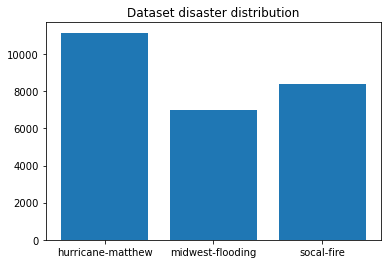

In [3]:
distribution = train_df[["disaster", "size"]].groupby("disaster").count().rename(columns={"size": "count"})
plt.title("Dataset disaster distribution")
plt.bar(x=distribution.index, height=distribution["count"])
distribution

# Image sizes across disasters

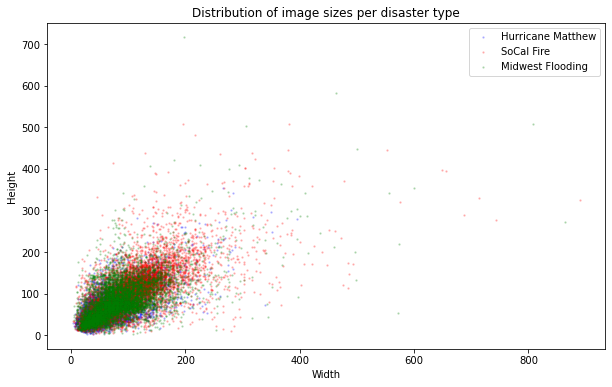

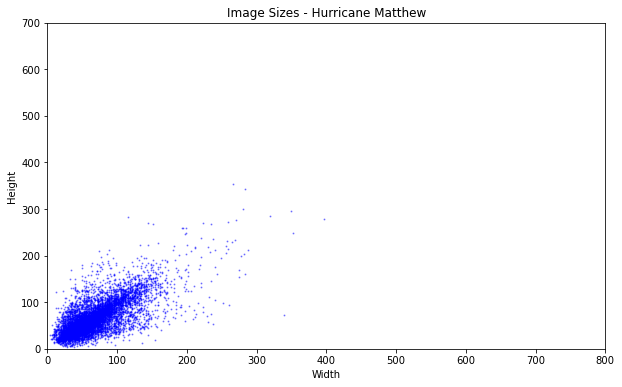

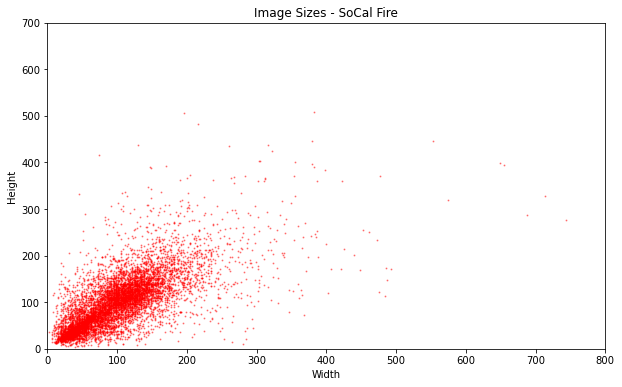

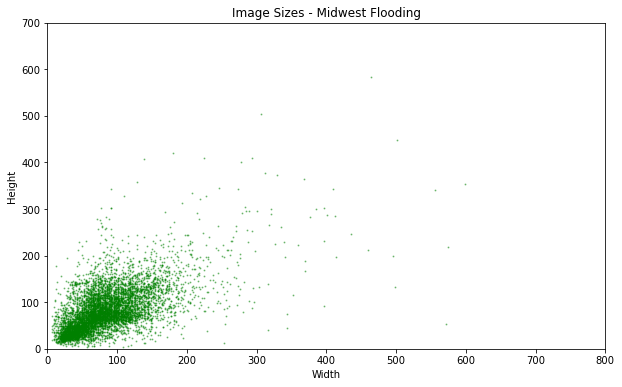

In [4]:
hurricane_matthew = train_df[train_df['disaster'] == 'hurricane-matthew']['image']
socal_fire = train_df[train_df['disaster'] == 'socal-fire']['image']
midwest_flooding = train_df[train_df['disaster'] == 'midwest-flooding']['image']

sizes_hurricane_matthew = np.array([img.shape for img in hurricane_matthew])
sizes_socal_fire = np.array([img.shape for img in socal_fire])
sizes_midwest_flooding = np.array([img.shape for img in midwest_flooding])

plt.figure(figsize=(10, 6))
plt.scatter(sizes_hurricane_matthew[:, 1], sizes_hurricane_matthew[:, 0], alpha=0.2, label="Hurricane Matthew", color="blue", s=2)
plt.scatter(sizes_socal_fire[:, 1], sizes_socal_fire[:, 0], alpha=0.2, label="SoCal Fire", color="red", s=2)
plt.scatter(sizes_midwest_flooding[:, 1], sizes_midwest_flooding[:, 0], alpha=0.2, label="Midwest Flooding", color="green", s=2)

plt.title("Distribution of image sizes per disaster type")
plt.xlabel("Width")
plt.ylabel("Height")
plt.legend()
plt.show()


def plot_image_sizes(sizes, title, color):
    plt.figure(figsize=(10, 6))
    plt.scatter(sizes[:, 1], sizes[:, 0], alpha=0.4, color=color, s=1)
    plt.title("Image Sizes - " + title)
    plt.ylim(0, 700)
    plt.xlim(0, 800)
    plt.xlabel("Width")
    plt.ylabel("Height")
    plt.show()

plot_image_sizes(sizes_hurricane_matthew, "Hurricane Matthew", "blue")
plot_image_sizes(sizes_socal_fire, "SoCal Fire", "red")
plot_image_sizes(sizes_midwest_flooding, "Midwest Flooding", "green")


# Distribution of labels

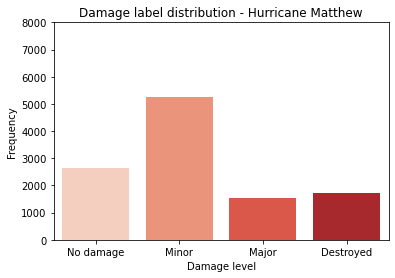

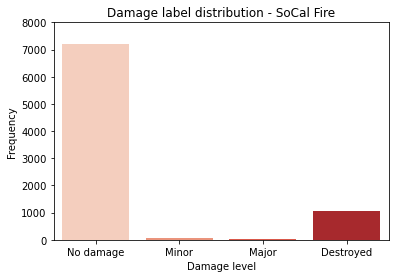

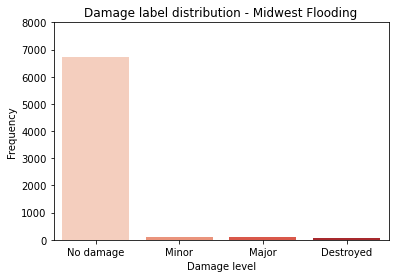

In [5]:
damage_labels_hurricane_matthew = np.array(train_df[train_df['disaster'] == 'hurricane-matthew']["label"])
damage_labels_socal_fire = np.array(train_df[train_df['disaster'] == 'socal-fire']["label"])
damage_labels_midwest_flooding = np.array(train_df[train_df['disaster'] == 'midwest-flooding']["label"])

def plot_label_distribution_each_disaster(labels, title):
    plt.figure(figsize=(6, 4))
    sns.countplot(x=labels, palette="Reds")
    plt.title("Damage label distribution - " + title)
    plt.ylim(0, 8000)
    plt.xlabel('Damage level')
    plt.ylabel('Frequency')
    plt.xticks(range(4), ['No damage', 'Minor', 'Major', 'Destroyed'])
    plt.show()

plot_label_distribution_each_disaster(damage_labels_hurricane_matthew, 'Hurricane Matthew')
plot_label_distribution_each_disaster(damage_labels_socal_fire, 'SoCal Fire')
plot_label_distribution_each_disaster(damage_labels_midwest_flooding, 'Midwest Flooding')

# Task A - EDA and final features

**RGB and HSV channels**

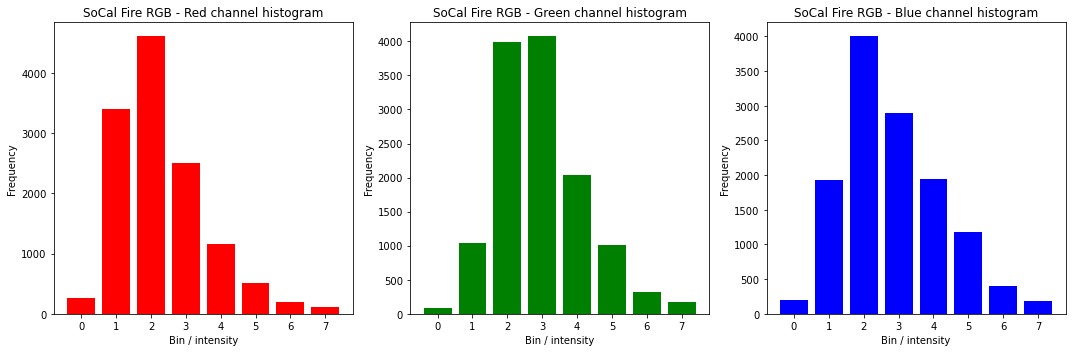

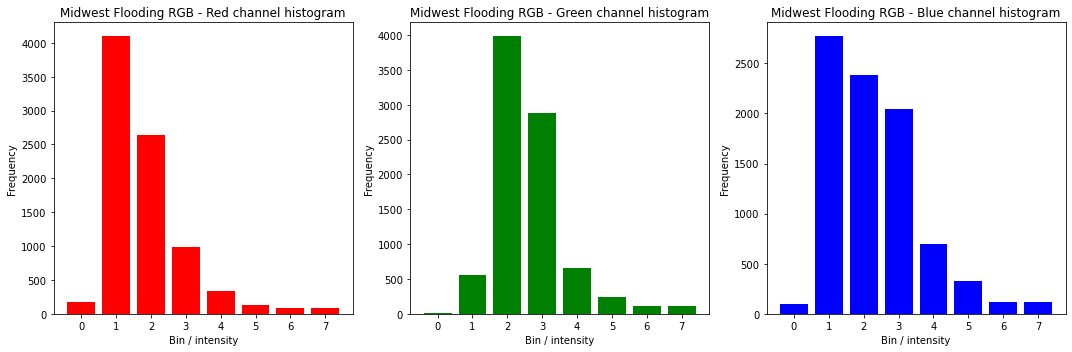

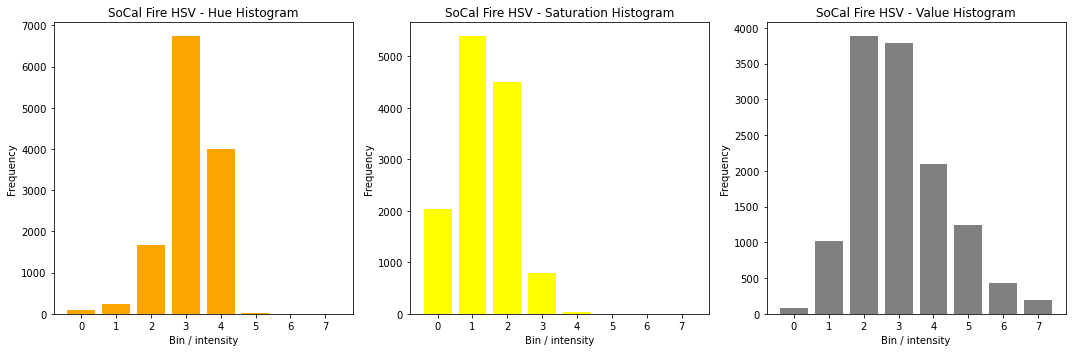

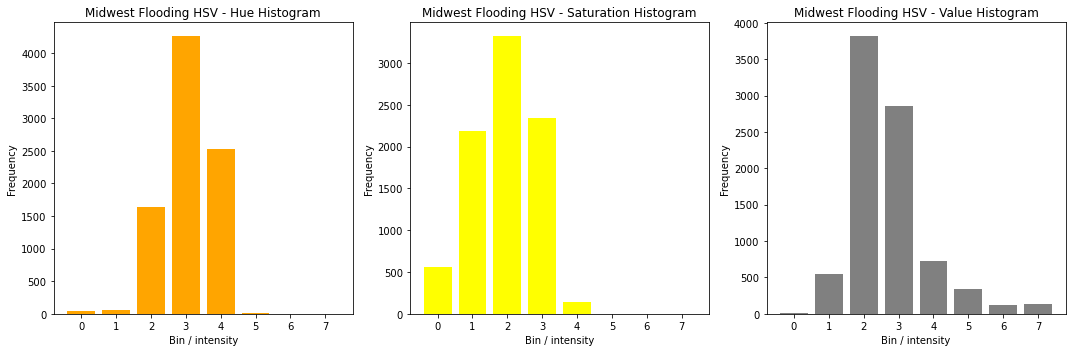

In [6]:
from skimage.color import rgb2hsv


# For this task we looked at the difference in color for SoCal Fire and Midwest Flooding

# First we defined our dataframe with only SoCal and Midwest

socal_fire_df = train_df[train_df['disaster'] == 'socal-fire']
midwest_flood_df = train_df[train_df['disaster'] == 'midwest-flooding']


# Then we plotted a histogram for every RGB channel per disaster, where each histogram has a total of 8 bins
# Shows the average of all images for each channel

# Calculate histograms for RGB channels
def calculate_rgb_histograms(image_data, bins=8):
    histograms = {'red': [], 'green': [], 'blue': []}
    for image in image_data:
        histograms['red'].append(np.histogram(image[:, :, 0], bins=bins, range=(0, 255))[0])
        histograms['green'].append(np.histogram(image[:, :, 1], bins=bins, range=(0, 255))[0])
        histograms['blue'].append(np.histogram(image[:, :, 2], bins=bins, range=(0, 255))[0])
    for key in histograms:
        histograms[key] = np.mean(histograms[key], axis=0)
    return histograms

# Plot the histograms
def plot_rgb_histograms(histograms, title):
    fig, axes = plt.subplots(1, 3, figsize=(15, 5))  # Adjust the figsize if necessary
    color_labels = ['Red', 'Green', 'Blue']
    colors = ['red', 'green', 'blue']
    
    for i, ax in enumerate(axes):
        ax.bar(range(len(histograms[color_labels[i].lower()])), histograms[color_labels[i].lower()], color=colors[i])
        ax.set_title(f'{title} - {color_labels[i]} channel histogram')
        ax.set_xlabel('Bin / intensity')
        ax.set_ylabel('Frequency')
    
    plt.tight_layout() 
    plt.show()



# Then we did the same for each channel in HSV


# Calculate histograms for HSV channels
def calculate_hsv_histograms(image_data, bins=8):
    histograms = {'hue': [], 'saturation': [], 'value': []}
    for image in image_data:
        hsv_image = rgb2hsv(image)
        histograms['hue'].append(np.histogram(hsv_image[:, :, 0], bins=bins, range=(0, 1))[0])
        histograms['saturation'].append(np.histogram(hsv_image[:, :, 1], bins=bins, range=(0, 1))[0])
        histograms['value'].append(np.histogram(hsv_image[:, :, 2], bins=bins, range=(0, 1))[0])
    for key in histograms:
        histograms[key] = np.mean(histograms[key], axis=0)
    return histograms

# Plot the histograms
def plot_hsv_histograms(histograms, title):
    fig, axes = plt.subplots(1, 3, figsize=(15, 5))
    color_labels = ['Hue', 'Saturation', 'Value']
    colors = ['orange', 'yellow', 'grey']
    for i, ax in enumerate(axes):
        ax.bar(range(len(histograms[color_labels[i].lower()])), histograms[color_labels[i].lower()], color=colors[i])
        ax.set_title(f'{title} - {color_labels[i]} Histogram')
        ax.set_xlabel('Bin / intensity')
        ax.set_ylabel('Frequency')
    
    plt.tight_layout()
    plt.show()



# Calculate and plot histograms

# RGB
socal_fire_histograms = calculate_rgb_histograms(socal_fire_df['image'].values)
midwest_flood_histograms = calculate_rgb_histograms(midwest_flood_df['image'].values)

plot_rgb_histograms(socal_fire_histograms, 'SoCal Fire RGB')
plot_rgb_histograms(midwest_flood_histograms, 'Midwest Flooding RGB')

# HSV

socal_fire_hsv_histograms = calculate_hsv_histograms(socal_fire_df['image'].values)
midwest_flood_hsv_histograms = calculate_hsv_histograms(midwest_flood_df['image'].values)

plot_hsv_histograms(socal_fire_hsv_histograms, 'SoCal Fire HSV')
plot_hsv_histograms(midwest_flood_hsv_histograms, 'Midwest Flooding HSV')

# Task B - EDA and final features

**RGB and HSV channels**

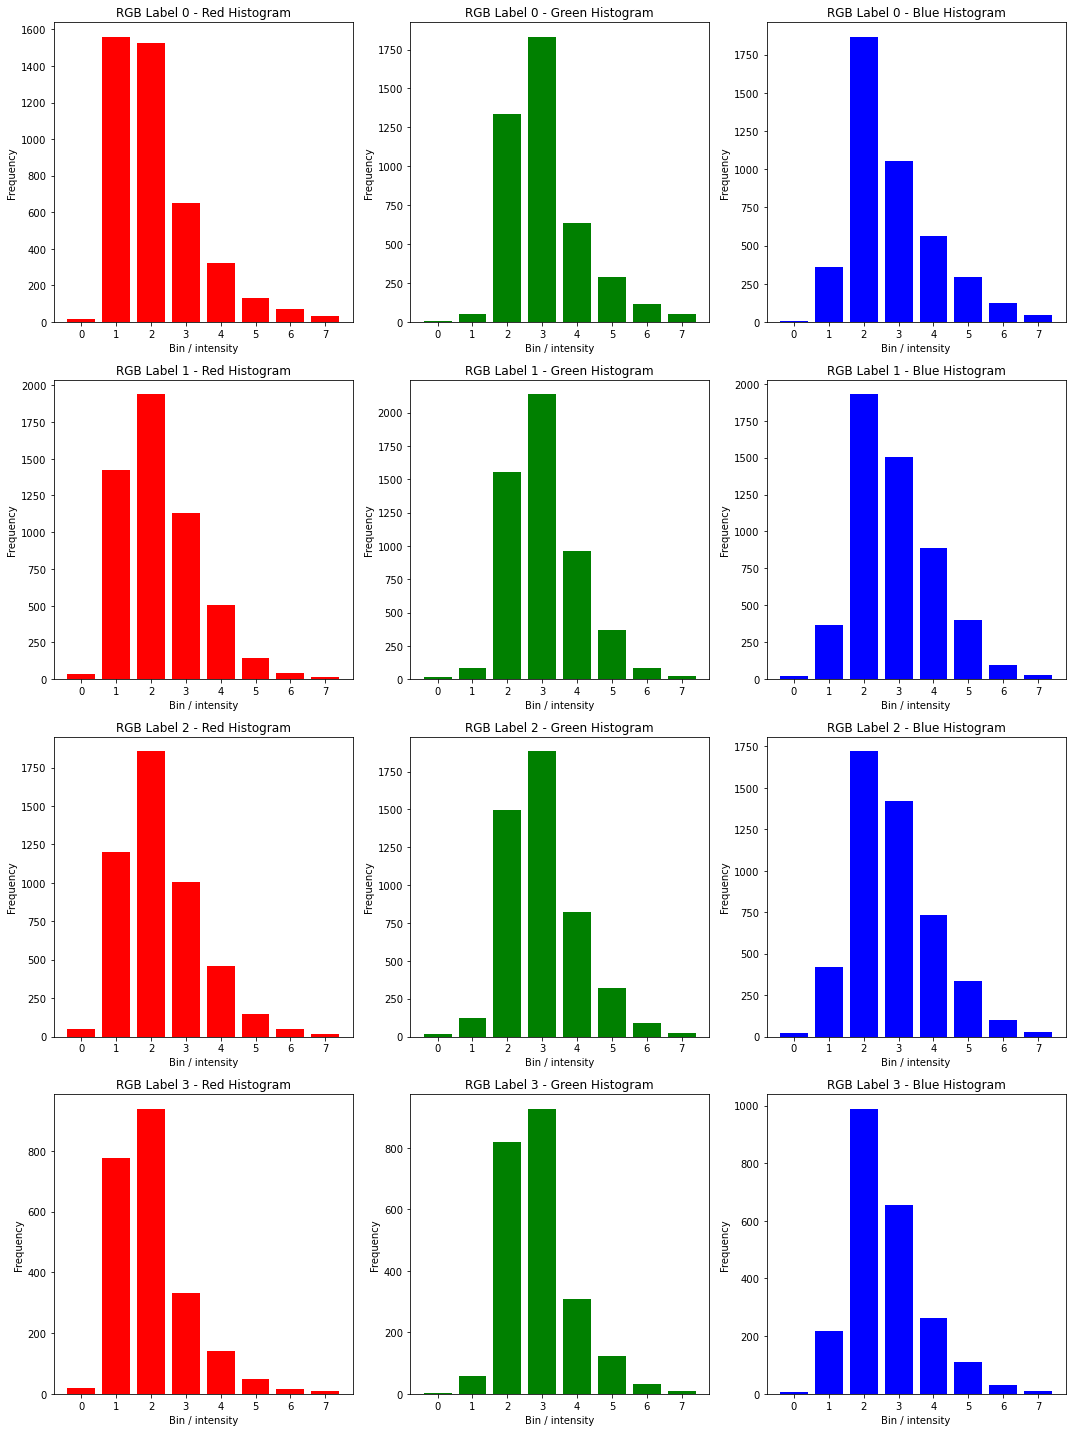

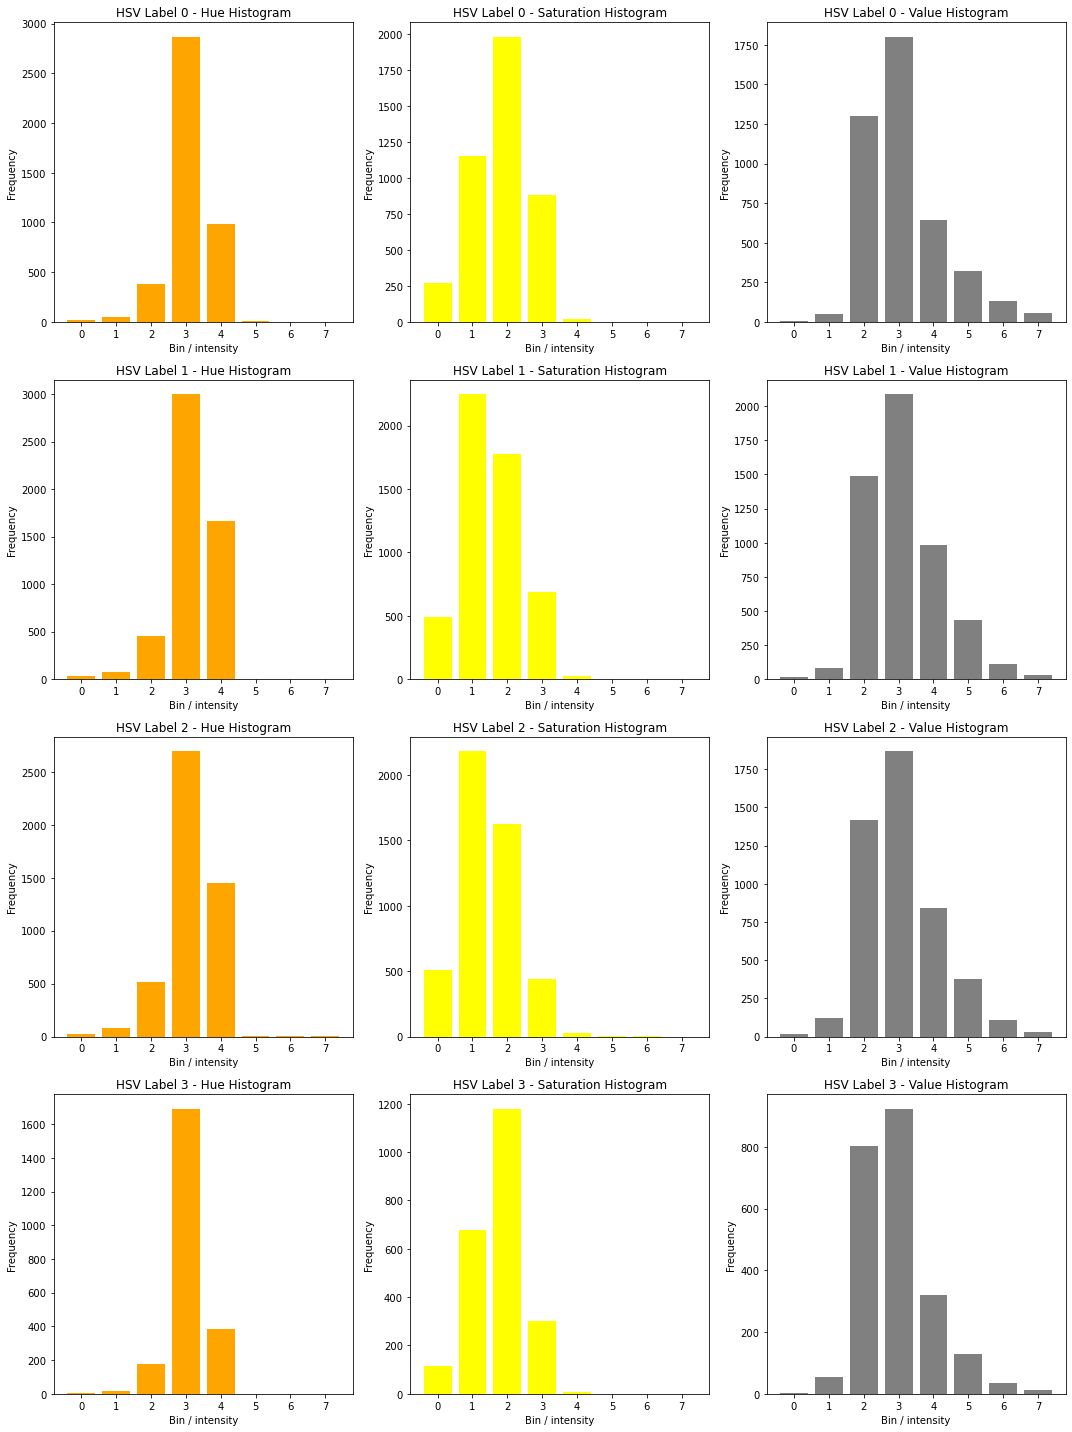

In [7]:
# The first features we looked at where RGB and HSV for each label


def plot_all_labels_histograms(histograms, title_prefix):
    fig, axes = plt.subplots(nrows=4, ncols=3, figsize=(15, 20))
    if 'red' in histograms[0]:
        color_labels = ['Red', 'Green', 'Blue']
    else:
        color_labels = ['Hue', 'Saturation', 'Value']
    if 'red' in histograms[0]:
        colors = ['red', 'green', 'blue'] 
    else:
        colors = ['orange', 'yellow', 'grey']
    
    for i, label in enumerate(labels):
        for j, (key, color) in enumerate(zip(color_labels, colors)):
            axes[i, j].bar(range(len(histograms[label][key.lower()])), histograms[label][key.lower()], color=color)
            axes[i, j].set_title(f'{title_prefix} {label} - {key} Histogram')
            axes[i, j].set_xlabel('Bin / intensity')
            axes[i, j].set_ylabel('Frequency')

    plt.tight_layout()
    plt.show()

# filter out labels
labels = [0, 1, 2, 3]
hurricane_data = {
    label: train_df[(train_df['disaster'] == 'hurricane-matthew') & (train_df['label'] == label)]['image'].values
    for label in labels
}

# Calculate, store and plot histograms for each label
rgb_histograms = {label: calculate_rgb_histograms(hurricane_data[label]) for label in labels}
hsv_histograms = {label: calculate_hsv_histograms(hurricane_data[label]) for label in labels}

plot_all_labels_histograms(rgb_histograms, 'RGB Label')
plot_all_labels_histograms(hsv_histograms, 'HSV Label')

**Contrast**

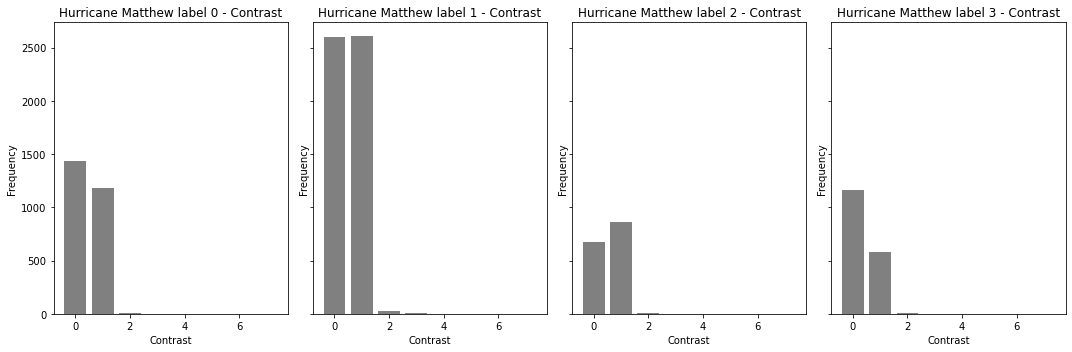

In [8]:
# Then we looked at contrast to see if there were any correlation between labels and variating intensity in the images

def compute_contrast_and_bin(image, bins=5):
    image_gray = rgb2gray(img_as_float(image))
    contrast = np.std(image_gray.flatten())
    bins_edges = np.linspace(0, np.max([image_gray.max(), 0.5]), bins+1)
    bin_index = np.digitize(contrast, bins_edges) - 1
    return bin_index

def calculate_contrast_histograms(data, bins=8):
    contrast_histograms = {label: np.zeros(bins) for label in labels}
    for label in labels:
        for image in data[label]:
            bin_index = compute_contrast_and_bin(image, bins)
            contrast_histograms[label][bin_index] += 1
    return contrast_histograms

def plot_contrast_histograms(histograms, title_prefix):
    fig, axes = plt.subplots(1, len(histograms), figsize=(15, 5), sharey=True)
    for i, (label, histogram) in enumerate(histograms.items()):
        axes[i].bar(range(len(histogram)), histogram, color='gray')
        axes[i].set_title(f'{title_prefix} {label} - Contrast')
        axes[i].set_xlabel('Contrast')
        axes[i].set_ylabel('Frequency')
    plt.tight_layout()
    plt.show()

contrast_histograms = calculate_contrast_histograms(hurricane_data)
plot_contrast_histograms(contrast_histograms, 'Hurricane Matthew label')

From the results of the plot, we can see that labels 2 and 3 have significant lower contrast. Label 0 is in the middle range, while label 1 is clearly higher than the other labels. The reason for this huge difference for label 1 may be caused by a larger amount of debris around the building. A large amount of debris may cause a high variation in intensity in the image (therefore higher contrast).

**Local Binary Pattern**

/home/ubuntu/.local/lib/python3.10/site-packages/skimage/feature/texture.py:360: UserWarning: Applying `local_binary_pattern` to floating-point images may give unexpected results when small numerical differences between adjacent pixels are present. It is recommended to use this function with images of integer dtype.
  warnings.warn(


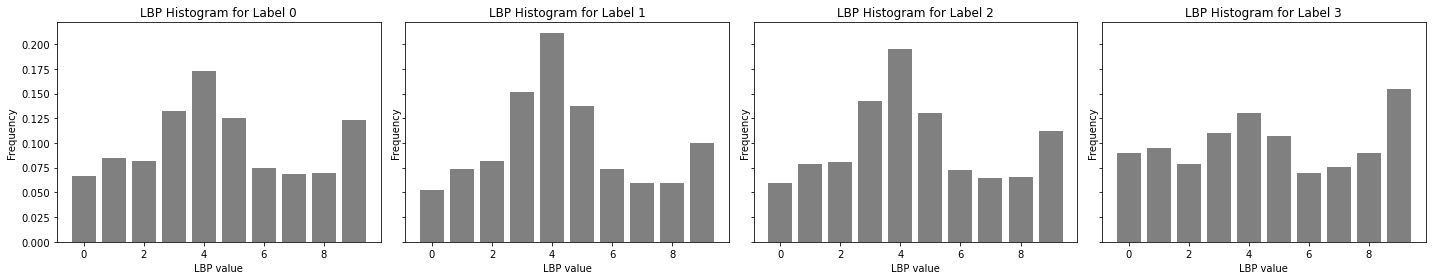

In [9]:
# Then we looked at LBP since this methode is good for see patterns of edges which is relevant after a hurricane might have destroyed a building

# LBP features
# Have to convert to grayscale since LBP only uses intensity and not color (P and R is neighbors and radius)
# Using uniform patterns to reduce complexity
def extract_lbp_features(img, P=8, R=1, method='uniform'):
    img_grayscaled = rgb2gray(img)
    lbp = local_binary_pattern(img_grayscaled, P, R, method)
    n_bins = int(lbp.max() + 1)
    hist, _ = np.histogram(lbp, density=True, bins=n_bins, range=(0, n_bins))
    return hist

# Dividing labels and store lbp info for each label
labels = [0, 1, 2, 3]
lbp_features_by_label = {}

for label in labels:
    images = train_df[(train_df['disaster'] == 'hurricane-matthew') & (train_df['label'] == label)]['image'].values
    lbp_features = [extract_lbp_features(img) for img in images]
    lbp_features_by_label[label] = lbp_features


def plot_lbp_histograms_by_label(lbp_features_by_label):
    fig, axes = plt.subplots(nrows=1, ncols=len(lbp_features_by_label), figsize=(20, 4), sharey=True)
    for i, label in enumerate(lbp_features_by_label):
        lbp_histograms = np.vstack(lbp_features_by_label[label])
        mean_histogram = np.mean(lbp_histograms, axis=0)
        axes[i].bar(range(len(mean_histogram)), mean_histogram, color='gray')
        axes[i].set_title(f'LBP Histogram for Label {label}')
        axes[i].set_xlabel('LBP value')
        axes[i].set_ylabel('Frequency')
    plt.tight_layout()
    plt.show()

plot_lbp_histograms_by_label(lbp_features_by_label)

As we can see form the average of the LBP for each label, we can say that 1 and 2 look very similar. Also label 0 seems similar to 1 and 2. However label 3 look distinctively different from the others. This makes sense given that the pattern of edges LBP can detect is different when a building is destoyed. For example walls can have fallen and/or moved to unnatural positions compared to a undamaged house. 0, 1 and 2 are similar because the building still standing meaning no serious changes to the overall pattern of edges.

# **Task A - Disaster Classification - Logistic Regression**

# Creating new dataframe, filter and shuffle

In [10]:
train_df = df

filtered_df = train_df[(train_df['disaster'] == 'socal-fire') | (train_df['disaster'] == 'midwest-flooding')].copy()

filtered_df['disaster'] = filtered_df['disaster'].map({'midwest-flooding': 0, 'socal-fire': 1}).astype(int)

# shuffle data
filtered_df = filtered_df.sample(frac=1, random_state=42).reset_index(drop=True)


# Sampling

In [11]:
print("-------------------------------------")
print("Before sampling data")

disaster_counts = filtered_df['disaster'].value_counts()
print("\nCounts for each disaster type:\n", disaster_counts)

total_records = disaster_counts.sum()
proportions = disaster_counts / total_records
print("\nProportions for each disaster type:\n", proportions)

print("\nDamage level distribution for Midwest flooding:")
print(filtered_df[filtered_df['disaster'] == 0]['label'].value_counts(normalize=True))

print("\nDamage level distribution for SoCal fire:")
print(filtered_df[filtered_df['disaster'] == 1]['label'].value_counts(normalize=True))


def balance_data(df, n_samples=None, random_state=42):
    balanced_df = pd.DataFrame()
    for label in df['label'].unique():
        label_df = df[df['label'] == label]
        if n_samples is None:
            n_samples = len(label_df)
        resampled_df = resample(label_df, replace=True, n_samples=n_samples, random_state=random_state)
        balanced_df = pd.concat([balanced_df, resampled_df], axis=0)
    return balanced_df

min_samples = min(filtered_df['label'].value_counts())

balanced_train_df = balance_data(filtered_df, n_samples=min_samples)

print("-------------------------------------")
print("After sampling data")

disaster_counts = balanced_train_df['disaster'].value_counts()
print("\nCounts for each disaster type:\n", disaster_counts)

total_records = disaster_counts.sum()
proportions = disaster_counts / total_records
print("\nProportions for each disaster type:\n", proportions)

print("\nDamage level distribution for Midwest flooding:")
print(balanced_train_df[balanced_train_df['disaster'] == 0]['label'].value_counts(normalize=True))

print("\nDamage level distribution for SoCal fire:")
print(balanced_train_df[balanced_train_df['disaster'] == 1]['label'].value_counts(normalize=True))

-------------------------------------
Before sampling data

Counts for each disaster type:
 1    8380
0    7004
Name: disaster, dtype: int64

Proportions for each disaster type:
 1    0.544722
0    0.455278
Name: disaster, dtype: float64

Damage level distribution for Midwest flooding:
0    0.961451
1    0.016276
2    0.013849
3    0.008424
Name: label, dtype: float64

Damage level distribution for SoCal fire:
0    0.859666
3    0.126969
1    0.008234
2    0.005131
Name: label, dtype: float64
-------------------------------------
After sampling data

Counts for each disaster type:
 1    313
0    247
Name: disaster, dtype: int64

Proportions for each disaster type:
 1    0.558929
0    0.441071
Name: disaster, dtype: float64

Damage level distribution for Midwest flooding:
2    0.384615
1    0.307692
0    0.267206
3    0.040486
Name: label, dtype: float64

Damage level distribution for SoCal fire:
3    0.415335
0    0.236422
1    0.204473
2    0.143770
Name: label, dtype: float64


# Making features (HSV and RGB)

In [12]:
def combine_histogram_features(image, bins=8):
    image_float = img_as_float(image)
    rgb_hist_features = np.concatenate([
        np.histogram(image_float[:, :, i], bins=bins, range=(0, 1), density=True)[0]
        for i in range(3)
    ])
    hsv_image = rgb2hsv(image_float)
    hsv_hist_features = np.concatenate([
        np.histogram(hsv_image[:, :, i], bins=bins, range=(0, 1), density=True)[0]
        for i in range(3)
    ])
    
    combined_features = np.concatenate([rgb_hist_features, hsv_hist_features])
    
    return combined_features



In [13]:
combined_feature_list = balanced_train_df['image'].apply(lambda img: combine_histogram_features(img))

combined_features_df = pd.DataFrame(list(combined_feature_list))

label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(balanced_train_df['disaster'])

scaler = StandardScaler()
X_scaled = scaler.fit_transform(combined_features_df)

X_train, X_test, y_train, y_test = train_test_split(X_scaled, y_encoded, test_size=0.2)

model = LogisticRegression(max_iter=1000, multi_class='multinomial', solver='lbfgs', random_state=42)
model.fit(X_train, y_train)

predictions = model.predict(X_test)
accuracy = accuracy_score(y_test, predictions)
print("Disaster classification accuracy (using combined RGB and HSV features): ", accuracy)

# Cross valdiation
cv_scores = cross_val_score(model, X_scaled, y_encoded, cv=5, scoring='accuracy')

print("Accuracies for each fold:", cv_scores)
print("Mean cross-validation accuracy:", np.mean(cv_scores))

Disaster classification accuracy (using combined RGB and HSV features):  0.9732142857142857
Accuracies for each fold: [0.78571429 0.92857143 0.91964286 0.96428571 0.95535714]
Mean cross-validation accuracy: 0.9107142857142858


In [14]:
combined_features_df

,0,1,2,3,4,5,6,7,8,9,...,38,39,40,41,42,43,44,45,46,47
0,0.643367,5.023469,1.357653,0.864796,0.080612,0.019388,0.010204,0.000510,0.002041,1.598980,...,0.0,0.0,0.002041,1.598980,3.611224,2.352551,0.347449,0.063776,0.018367,0.005612
1,0.022816,0.718717,3.248485,3.761854,0.248128,0.000000,0.000000,0.000000,0.000000,0.042781,...,0.0,0.0,0.000000,0.042781,0.781462,5.909447,1.203565,0.062745,0.000000,0.000000
2,0.039216,2.011765,3.709804,0.925490,0.533333,0.419608,0.313725,0.047059,0.000000,0.427451,...,0.0,0.0,0.000000,0.427451,3.325490,2.368627,0.780392,0.490196,0.458824,0.149020
3,0.313649,3.899044,2.673854,0.766479,0.337172,0.009802,0.000000,0.000000,0.000000,0.825288,...,0.0,0.0,0.000000,0.825288,4.163685,2.375888,0.294046,0.268562,0.072531,0.000000
4,0.020418,1.920174,2.724301,2.574423,0.566060,0.122943,0.065164,0.006516,0.000434,0.399674,...,0.0,0.0,0.000434,0.388379,2.198208,3.098344,1.501819,0.561282,0.214173,0.037361
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
555,0.002658,1.134884,6.059801,0.063787,0.108970,0.531561,0.098339,0.000000,0.000000,0.021262,...,0.0,0.0,0.000000,0.018605,0.077076,7.096346,0.079734,0.260465,0.465116,0.002658
556,0.008593,0.128894,6.977444,0.317938,0.045829,0.028643,0.057286,0.435374,0.000000,0.025779,...,0.0,0.0,0.000000,0.022914,0.048693,7.283924,0.114572,0.034372,0.051557,0.443967
557,0.002658,1.134884,6.059801,0.063787,0.108970,0.531561,0.098339,0.000000,0.000000,0.021262,...,0.0,0.0,0.000000,0.018605,0.077076,7.096346,0.079734,0.260465,0.465116,0.002658
558,0.055385,1.341538,3.042051,0.957949,0.640000,0.082051,0.061538,1.819487,0.016410,0.221538,...,0.0,0.0,0.016410,0.205128,1.099487,2.896410,1.478974,0.402051,0.071795,1.829744


# Predicting and writing to csv file

In [15]:
# Here we download the test dataset, generate the same features as we did in the training, and make prediction which is written to a csv file
test_df = pd.read_hdf('../../data/Regression/test_fire_flooding.h5', 'test_images')

test_features_list = [combine_histogram_features(img) for img in test_df['image'].values]
test_features_df = pd.DataFrame(test_features_list)

model.fit(X_train, y_train)

X_test_scaled = scaler.transform(test_features_df)
test_predictions = model.predict(X_test_scaled)

predictions_df = pd.DataFrame(test_predictions, columns=['pred'])
predictions_df.to_csv("test_images_flooding-fire_predictions.csv", index=False)

# Task B - Damage level classification - Creating new dataframe, filter, sample and shuffle

In [16]:
train_df = df

filtered_df = train_df[(train_df['disaster'] == 'hurricane-matthew')].copy()

# shuffle data
filtered_df = filtered_df.sample(frac=1, random_state=42).reset_index(drop=True)


# Sampling for Hurricane Matthew

In [17]:
print("-------------------------------------")
print("Before sampling data")

disaster_counts = filtered_df['label'].value_counts()
print("\nCounts for each label type:\n", disaster_counts)

total_records = disaster_counts.sum()
proportions = disaster_counts / total_records
print("\nProportions for each disaster type:\n", proportions)

min_samples = min(filtered_df['label'].value_counts())

balanced_train_df = balance_data(filtered_df, n_samples=min_samples)

print("-------------------------------------")
print("After sampling data")

disaster_counts = balanced_train_df['label'].value_counts()
print("\nCounts for each label type:\n", disaster_counts)

total_records = disaster_counts.sum()
proportions = disaster_counts / total_records
print("\nProportions for each disaster type:\n", proportions)


balanced_train_df = balanced_train_df.sample(frac=1, random_state=42).reset_index(drop=True)
balanced_train_df.head(20)

-------------------------------------
Before sampling data

Counts for each label type:
 1    5236
0    2631
3    1740
2    1544
Name: label, dtype: int64

Proportions for each disaster type:
 1    0.469554
0    0.235943
3    0.156040
2    0.138463
Name: label, dtype: float64
-------------------------------------
After sampling data

Counts for each label type:
 0    1544
3    1544
1    1544
2    1544
Name: label, dtype: int64

Proportions for each disaster type:
 0    0.25
3    0.25
1    0.25
2    0.25
Name: label, dtype: float64


,disaster,image,label,height,width,size
0,hurricane-matthew,"[[[71, 111, 85], [60, 98, 72], [52, 87, 63], [...",3,54,53,8586
1,hurricane-matthew,"[[[61, 90, 81], [65, 95, 85], [62, 91, 80], [6...",3,50,52,7800
2,hurricane-matthew,"[[[71, 98, 94], [70, 96, 92], [77, 102, 98], [...",2,65,65,12675
3,hurricane-matthew,"[[[63, 100, 80], [64, 101, 81], [62, 100, 79],...",0,55,48,7920
4,hurricane-matthew,"[[[79, 90, 86], [90, 102, 94], [117, 129, 114]...",2,35,72,7560
5,hurricane-matthew,"[[[122, 145, 149], [120, 143, 147], [115, 138,...",0,93,84,23436
6,hurricane-matthew,"[[[62, 91, 76], [62, 91, 76], [50, 76, 62], [5...",3,30,36,3240
7,hurricane-matthew,"[[[40, 73, 54], [45, 81, 60], [48, 86, 63], [5...",0,47,47,6627
8,hurricane-matthew,"[[[78, 104, 94], [73, 99, 89], [69, 94, 84], [...",0,68,42,8568
9,hurricane-matthew,"[[[55, 93, 69], [55, 91, 69], [54, 89, 68], [5...",0,53,47,7473


# Features - damage level classification

**RGB/HSV, LBG and contrast**

In [18]:
def extract_lbp_features(image, P=8, R=1, method='uniform'):
    image_gray = rgb2gray(image)
    lbp = local_binary_pattern(image_gray, P, R, method)
    n_bins = int(lbp.max() + 1)
    hist, _ = np.histogram(lbp, density=True, bins=n_bins, range=(0, n_bins))
    return hist

def compute_contrast_features(image, bins=8):
    image_gray = color.rgb2gray(img_as_float(image))
    contrast = np.std(image_gray)
    contrast_normalized = contrast / image_gray.max()
    binned_contrast = np.digitize(contrast_normalized, bins=np.linspace(0, 1, bins))
    return np.eye(bins)[binned_contrast - 1]

lbp_features = balanced_train_df['image'].apply(lambda img: extract_lbp_features(img))
lbp_features_df = pd.DataFrame(lbp_features.tolist())
lbp_features_df.columns = [f'lbp_{i}' for i in range(lbp_features_df.shape[1])] 

balanced_train_df['combined_features'] = balanced_train_df['image'].apply(combine_histogram_features)
combined_features_df = pd.DataFrame(balanced_train_df['combined_features'].tolist(), index=balanced_train_df.index)
combined_features_df.columns = [f'combined_{i}' for i in range(combined_features_df.shape[1])]

balanced_train_df['contrast_features'] = balanced_train_df['image'].apply(compute_contrast_features)
contrast_features_df = pd.DataFrame(np.vstack(balanced_train_df['contrast_features'].values))
contrast_features_df.columns = [f'contrast_bin_{i}' for i in range(contrast_features_df.shape[1])]


new_features_df = pd.concat([lbp_features_df, combined_features_df, contrast_features_df], axis=1)

/home/ubuntu/.local/lib/python3.10/site-packages/skimage/feature/texture.py:360: UserWarning: Applying `local_binary_pattern` to floating-point images may give unexpected results when small numerical differences between adjacent pixels are present. It is recommended to use this function with images of integer dtype.
  warnings.warn(


In [19]:
new_features_df

,lbp_0,lbp_1,lbp_2,lbp_3,lbp_4,lbp_5,lbp_6,lbp_7,lbp_8,lbp_9,...,combined_46,combined_47,contrast_bin_0,contrast_bin_1,contrast_bin_2,contrast_bin_3,contrast_bin_4,contrast_bin_5,contrast_bin_6,contrast_bin_7
0,0.104472,0.100978,0.080713,0.092243,0.090496,0.079665,0.068134,0.083159,0.118099,0.182041,...,0.025157,0.027952,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.116538,0.107308,0.074615,0.069231,0.076923,0.067692,0.055000,0.100385,0.124615,0.207692,...,0.006154,0.000000,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.099645,0.092308,0.081893,0.089231,0.110296,0.099172,0.073373,0.090888,0.094911,0.168284,...,0.658935,0.263195,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.048106,0.073485,0.079167,0.151515,0.226515,0.143182,0.077273,0.054924,0.050758,0.095076,...,0.221212,0.184848,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.048810,0.077778,0.095238,0.152778,0.188889,0.134127,0.080556,0.066667,0.055952,0.099206,...,0.003175,0.000000,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6171,0.065309,0.078652,0.077809,0.127528,0.179775,0.131180,0.083146,0.065309,0.071910,0.119382,...,0.024719,0.024719,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
6172,0.038302,0.060041,0.079710,0.170290,0.259058,0.151139,0.069617,0.053054,0.040631,0.078157,...,0.006211,0.000000,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
6173,0.100470,0.103995,0.075793,0.081669,0.097532,0.093420,0.064042,0.078731,0.105758,0.198590,...,0.056404,0.014101,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
6174,0.047826,0.097826,0.095652,0.141304,0.191304,0.141304,0.076087,0.050000,0.050000,0.108696,...,0.000000,0.000000,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


# Training the model

In [20]:
X = new_features_df.values
y = balanced_train_df['label'].values.astype(int)

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2)

model = LogisticRegression(max_iter=10000)

# Cross validation
cv_scores = cross_val_score(model, X_scaled, y, cv=5, scoring='f1_weighted')

print("F1 Scores for each fold:", cv_scores)
print("Mean F1 Score:", np.mean(cv_scores))

F1 Scores for each fold: [0.54988532 0.54524266 0.53438438 0.56437343 0.55145606]
Mean F1 Score: 0.5490683698122785


# Predicting and writing to file

In [25]:
# Here we download the test dataset, generate the same features as we did in the training, and make prediction which is written to a csv file
test_df = pd.read_hdf('../../data/Regression/test_hurricane.h5', 'test_images')

test_features_list = [np.concatenate([extract_lbp_features(img), combine_histogram_features(img), compute_contrast_features(img)]) for img in test_df['image'].values]
test_features_df = pd.DataFrame(test_features_list)

model.fit(X_train, y_train)

X_test_scaled = scaler.transform(test_features_df)
test_predictions = model.predict(X_test_scaled)

predictions_df = pd.DataFrame(test_predictions, columns=['pred'])
predictions_df.to_csv("./test_images_hurricane-matthew_predictions.csv", index=False)

/home/ubuntu/.local/lib/python3.10/site-packages/skimage/feature/texture.py:360: UserWarning: Applying `local_binary_pattern` to floating-point images may give unexpected results when small numerical differences between adjacent pixels are present. It is recommended to use this function with images of integer dtype.
  warnings.warn(
